# <b>0. IMPORTING LIBRARIES

In [137]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import cv2 as cv
import random
from tqdm import tqdm
import xml.etree.ElementTree as ET
import xml.dom.minidom

# <b> 1. Paths to directories and files

### 1.1 Donwloading the MNIST dataset from TF and preparing the directories to save the new dataset

In [2]:
#donwload dataset mnist
(x_train_ori, y_train_ori), (x_test_ori, y_test_ori) = tf.keras.datasets.mnist.load_data()
assert x_train_ori.shape == (60000, 28, 28)
assert x_test_ori.shape == (10000, 28, 28)
assert y_train_ori.shape == (60000,)
assert y_test_ori.shape == (10000,)

In [3]:
#files path in a dictionary
paths = dict()

paths['main'] = os.path.dirname('D:\Javi\Python\MNIST_OD')
paths['dataset'] = os.path.join(paths['main'], 'MNIST_dataset')
paths['train_data'] = os.path.join(paths['dataset'], 'train')
paths['test_data'] = os.path.join(paths['dataset'], 'test')
# paths['test_img'] = os.path.join(paths['test_data'], 'test')

### 1.2 Preparing the dataset to generate new data

In [4]:
#convert the raw data to a dataset-object

train = tf.data.Dataset.from_tensor_slices((x_train_ori,y_train_ori))
test = tf.data.Dataset.from_tensor_slices((x_test_ori,y_test_ori))

#genetating the input data format
BATCH = 5
FETCH = 6
SHUFFLE = 600


train = train.batch(BATCH).shuffle(SHUFFLE).prefetch(FETCH)
test = test.batch(BATCH).prefetch(FETCH)

2023-03-08 00:53:32.922802: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Functions to preproccess images in to the new dataset

In [5]:
# function to rotate images

def rotate_image(image, angle, not_print = True):
    '''
    This function rotate the image and plot it
    Imput params:
        image = array like,
        angle = counterclockwise rotate angle (degrees),
        not_print = if 'True' do not plot an image
    Return:
        image = image rotated [array like]
    '''
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)
    if not not_print:
        plt.imshow(result, cmap='gray')
        plt.show()
    return result

In [161]:
# Create a pascal voc format file from the dictionary data

def dict_to_xml(tag, d, attribute=None):
    '''
    This function create a xml object from scratch
    attributes:
    - tag : str name of the top tag
    - d : dict like to create child elemments in xml
    - attribute : attribute for top tag (default=None)
    return: xml object
    '''
    elem = ET.Element(tag)
    if attribute is not None:
        elem.attrib = attribute
    for key, val in d.items():
        child = ET.Element(key)
        child.text = str(val)
        elem.append(child)
    return elem


def add_dict_to_xml(xml, d):
    '''
    This function modify chilid elemments
    for an xml object
    attributes:
    - xml : xml parent obj
    - d : dict like to create child elemments in xml
    return: None
    '''
    elem = xml
    for key, val in d.items():
        child = ET.Element(key)
        child.text = str(val)
        elem.append(child)


def toPascalVocFormat(name_of_the_file, directory_name, dictionary_data):
    '''
    This function create a xml file.
    Attributes:
    - name_of_the_file: name of the file (str)
    - directory_name: directory path to save the file (str)
    - d: list of dict len(d)=number of objects in the image
      d example: [{'name': 'Name_of_the_file', 'x_min': 'int',
                   'ymin': 'int', 'xmax': 'int', 'ymax': 'int'}]
    return: None
    '''
    # Baseline data in a dictionary format
    basicXmlFileDict = {'folder': directory_name,
                        'file': name_of_the_file+'.xml',
                        'path': os.path.join(directory_name,
                                             name_of_the_file+'.xml'),
                        'source': 'MNIST dataset for OD by Javi',
                        'size': 'size of the image',
                        'segmented': '0'}

    sizeDict = {'width': '140', 'height': '140', 'depth': '1'}

    dummyObject = {'name': 'Name_of_the_file', 'pose': 'Unspectified',
                   'truncated': '0', 'difficult': '0'}

    dummyObjectBNB = {'x_min': 'int', 'ymin': 'int',
                      'xmax': 'int', 'ymax': 'int'}

    dummy_xml = dict_to_xml('annotations', basicXmlFileDict,
                            attribute={'verified': 'no'})
    add_dict_to_xml(dummy_xml.find('size'), sizeDict)

    for item in dictionary_data:
        dummyObject['name'] = item['name']
        dummyObjectBNB['x_min'] = item['x_min']
        dummyObjectBNB['ymin'] = item['ymin']
        dummyObjectBNB['xmax'] = item['xmax']
        dummyObjectBNB['ymax'] = item['ymax']
        add_dict_to_xml(dummy_xml, dummyObject)
        ET.SubElement(dummy_xml[-1], 'bndbox')
        add_dict_to_xml(dummy_xml[-1].find('bndbox'), dummyObject)
    # Creating a xml in the directory
    f = open(basicXmlFileDict['path'], "r")
    file = ET.tostring(new_xml)
    dom = xml.dom.minidom.parseString(file)
    pretty_xml_as_string = dom.toprettyxml()
    f.write(pretty_xml_as_string)
    f.close()

In [ ]:
# Creating a function to increase the accuracy of the bounding box on the image

def clossing_bnb(image, possition_list):
    '''
    This function take an image and the possition of an object in the image
    and try to close the box arround the object til the first pixel not dark
    Attributes:
    - image: ndarry of the image
    - possition_list: list of the initial possition of the object (list of lists)
    return: new possition of the objects (list of lists)
    '''
    for point in possition_list:
        pass

In [32]:
# function to create a dataset image

def image_generator(tf_dataset, number_of_images):
    # For every number_of_images that it is going to be created:
    images, labels = tf_dataset.as_numpy_iterator().next()
    batch_size = images.shape[0]
    listOfPositions = list(range(batch_size))
    for numb in tqdm(range(number_of_images)):
        # take a banch of the dataset
        images, labels = tf_dataset.as_numpy_iterator().next()
        numberOfImages = random.randint(1, batch_size)
        # take a random numberOfImages from the banch
        indexOfImages = random.sample(listOfPositions, numberOfImages)
        # generate a back image
        img = np.zeros((140, 140), dtype=np.uint8)
        positionList = list()
        # For every image chose:
        for noi in range(numberOfImages):
            # Rotate the image and scaled 0.5 to 1.5 times
            rotationAngle = random.randint(-45, 45)
            scaleFactor = round((1.5*random.random()+0.5)*28)
            # print(scaleFactor)
            size = (scaleFactor, scaleFactor)
            stopper = 0
            # For every number noi, try to find a possition to do not overlap each other (5 tries):
            while stopper <= 5:
                # Generate random position
                x = random.randint(0, 140-scaleFactor)
                y = random.randint(0, 140-scaleFactor)
                # print(x,y)
                # Initilize the possition has available (not overlap)
                positionCompromised = False
                # Compare with the numbers already added to the black image
                for pos in positionList:
                    # print('Scales',pos[2],scaleFactor)
                    # print(x, y, x+scaleFactor, y+scaleFactor)
                    # print(pos[0],pos[1],pos[0]+pos[2],pos[1]+pos[2])
                    # Is the new number size bigger than the old one
                    if scaleFactor > pos[2]:
                        # The points are True if old point inside square ->(x, y), (x+scale, y+scale)
                        point1 = (pos[0] > x and pos[0] < x+scaleFactor) and (pos[1] > y and pos[1] < y+scaleFactor)
                        point2 = (pos[0]+pos[2] > x and pos[0]+pos[2] < x+scaleFactor) and (pos[1] > y and pos[1] < y+scaleFactor)
                        point3 = (pos[0]+pos[2] > x and pos[0]+pos[2] < x+scaleFactor) and (pos[1]+pos[2] > y and pos[1]+pos[2] < y+scaleFactor)
                        point4 = (pos[0] > x and pos[0] < x+scaleFactor) and (pos[1]+pos[2] > y and pos[1]+pos[2] < y+scaleFactor)
                    else:
                        # The points are True if new point inside square -> pos
                        point1 = (x > pos[0] and x < pos[0]+pos[2]) and (y > pos[1] and y < pos[1]+pos[2])
                        point2 = (x+scaleFactor > pos[0] and x+scaleFactor < pos[0]+pos[2]) and (y > pos[1] and y < pos[1]+pos[2])
                        point3 = (x+scaleFactor > pos[0] and x+scaleFactor < pos[0]+pos[2]) and (y+scaleFactor > pos[1] and y+scaleFactor < pos[1]+pos[2])
                        point4 = (x > pos[0] and x < pos[0]+pos[2]) and (y+scaleFactor > pos[1] and y+scaleFactor < pos[1]+pos[2])
                    # If any point is True the image is ocluding other one and is not included
                    if point1 or point2 or point3 or point4:
                        # print('denegado')
                        positionCompromised = True
                    # print(scaleFactor > pos[2],point1,point2,point3,point4)
                if len(positionList) == 0:
                    positionList.append([x, y, scaleFactor])
                    img[x:x+scaleFactor, y:y+scaleFactor] = rotate_image(cv.resize(images[noi], size), 
                                                                         rotationAngle, not_print = True)
                    stopper = 10
                elif not positionCompromised:
                    # print('Premio')
                    positionList.append([x, y, scaleFactor])
                    img[x:x+scaleFactor, y:y+scaleFactor] = rotate_image(cv.resize(images[noi], size), 
                                                                         rotationAngle, not_print = True)
                    stopper = 10
                stopper += 1
        plt.imshow(img)
        plt.show()

  0%|                                                     | 0/3 [00:00<?, ?it/s]

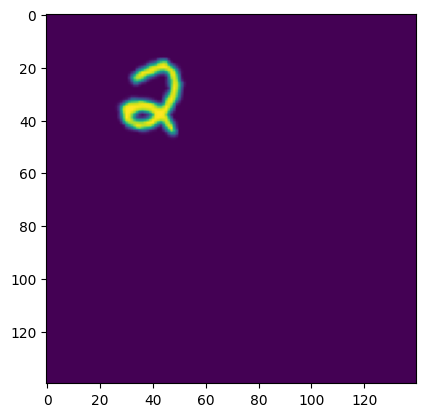

 33%|███████████████                              | 1/3 [00:00<00:00,  4.84it/s]

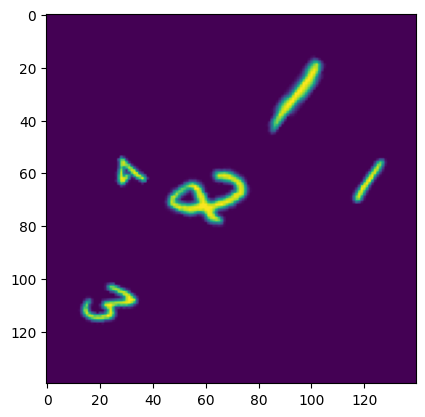

 67%|██████████████████████████████               | 2/3 [00:00<00:00,  4.71it/s]

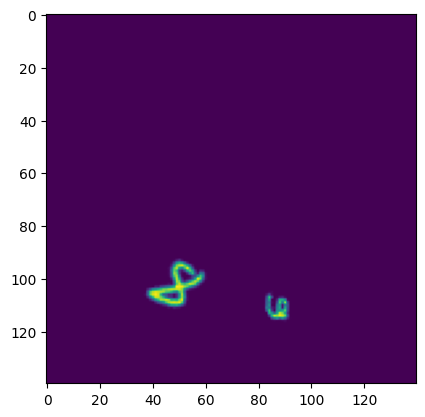

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


In [33]:
#Creatting a seed, in order to get replicable solution
# random.seed(13)

image_generator(train, 3)


In [13]:
A, B = train.as_numpy_iterator().next()

In [14]:
A.shape

(5, 28, 28)

In [ ]:
numberOfImages = random.randint(1,5)
indexOfImages = random.sample([1,2,3,4,5],numberOfImages)
rotationAngle = random.randint(-90,90)
scaleFactor = random.random()+0.5
size = (round(scaleFactor*28),round(scaleFactor*28))
img = tf.zeros((140,140),dtype=np.uint8)

In [ ]:
rotate_image(cv.resize(A[0],size), rotationAngle, not_print = False)

In [66]:
%config IPCompleter.use_jedi=False

In [34]:
file_test = os.path.normpath('/home/javi/fiftyone/open-images-v6/train/data/0a1dcafd3e7dc14d.xml')
'''
<annotation verified="yes">
	<folder>data</folder>
	<filename>0a1dcafd3e7dc14d.jpg</filename>
	<path>/home/javi/fiftyone/open-images-v6/train/data/0a1dcafd3e7dc14d.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1024</width>
		<height>650</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>Rodent</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>315</xmin>
			<ymin>224</ymin>
			<xmax>700</xmax>
			<ymax>650</ymax>
		</bndbox>
	</object>
	<object>
		<name>Rodent</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>420</xmin>
			<ymin>26</ymin>
			<xmax>675</xmax>
			<ymax>279</ymax>
		</bndbox>
	</object>
</annotation>
'''

'\n<annotation verified="yes">\n\t<folder>data</folder>\n\t<filename>0a1dcafd3e7dc14d.jpg</filename>\n\t<path>/home/javi/fiftyone/open-images-v6/train/data/0a1dcafd3e7dc14d.jpg</path>\n\t<source>\n\t\t<database>Unknown</database>\n\t</source>\n\t<size>\n\t\t<width>1024</width>\n\t\t<height>650</height>\n\t\t<depth>3</depth>\n\t</size>\n\t<segmented>0</segmented>\n\t<object>\n\t\t<name>Rodent</name>\n\t\t<pose>Unspecified</pose>\n\t\t<truncated>1</truncated>\n\t\t<difficult>0</difficult>\n\t\t<bndbox>\n\t\t\t<xmin>315</xmin>\n\t\t\t<ymin>224</ymin>\n\t\t\t<xmax>700</xmax>\n\t\t\t<ymax>650</ymax>\n\t\t</bndbox>\n\t</object>\n\t<object>\n\t\t<name>Rodent</name>\n\t\t<pose>Unspecified</pose>\n\t\t<truncated>0</truncated>\n\t\t<difficult>0</difficult>\n\t\t<bndbox>\n\t\t\t<xmin>420</xmin>\n\t\t\t<ymin>26</ymin>\n\t\t\t<xmax>675</xmax>\n\t\t\t<ymax>279</ymax>\n\t\t</bndbox>\n\t</object>\n</annotation>\n'

In [40]:
tree = ET.parse(file_test)
root = tree.getroot()

In [69]:
print(root.attrib)
for child in  root:
    print(child.tag,child.text)

{'verified': 'yes'}
folder data
filename 0a1dcafd3e7dc14d.jpg
path /home/javi/fiftyone/open-images-v6/train/data/0a1dcafd3e7dc14d.jpg
source 
		
size 
		
segmented 0
object 
		
object 
		


In [142]:
new_xml = dict_to_xml('annotations', basicXmlFileDict, attribute={'verified': 'no'})

# new_xml = new_xml.find('size')

print(new_xml.tag, new_xml.attrib)
for child in new_xml:
    print(child.tag, child.text)


add_dict_to_xml(new_xml.find('size'), sizeDict)

file = ET.tostring(new_xml)

dom = xml.dom.minidom.parseString(file) # or xml.dom.minidom.parseString(xml_string)
pretty_xml_as_string = dom.toprettyxml()

print(file.decode())
print(pretty_xml_as_string)

annotations {'verified': 'no'}
folder MNIST_dataset/train
file name of the file
path MNIST_dataset/train/name
source dataset_by_Javi
size size of the image
segmented 0
<annotations verified="no"><folder>MNIST_dataset/train</folder><file>name of the file</file><path>MNIST_dataset/train/name</path><source>dataset_by_Javi</source><size>size of the image<width>140</width><height>140</height><depth>1</depth></size><segmented>0</segmented></annotations>
<?xml version="1.0" ?>
<annotations verified="no">
	<folder>MNIST_dataset/train</folder>
	<file>name of the file</file>
	<path>MNIST_dataset/train/name</path>
	<source>dataset_by_Javi</source>
	<size>
		size of the image
		<width>140</width>
		<height>140</height>
		<depth>1</depth>
	</size>
	<segmented>0</segmented>
</annotations>



In [158]:
ET.SubElement(new_xml, 'object')
new_xml[-1]

<Element 'object' at 0x7fafac0c8720>

In [37]:
!pip install xml-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.7 MB/s eta 0:00:00


In [38]:
!pip install uuid

  Preparing metadata (setup.py) ... done
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6502 sha256=b6ad3d834f6377f3dd8aecd71cac3cce25fb07b6c6fdf3463dfc9415c96fe40f
  Stored in directory: /home/javi/.cache/pip/wheels/05/d7/b4/4795d29c6decfffbf64c63e58b6c8b8bbfd4751488617dcd7a
Successfully built uuid


In [ ]:
                    if scaleFactor > pos[2]:
                        # The points are True if old point inside square ->(x, y), (x+scale, y+scale)
                        point1 = (pos[0] < x and pos[0] > x+scaleFactor) and (pos[1] < y and pos[1] > y+scaleFactor)
                        point2 = (pos[0]+pos[2] < x and pos[0]+pos[2] > x+scaleFactor) and (pos[1] < y and pos[1] > y+scaleFactor)
                        point3 = (pos[0]+pos[2] < x and pos[0]+pos[2] > x+scaleFactor) and (pos[1]+pos[2] < y and pos[1]+pos[2] > y+scaleFactor)
                        point4 = (pos[0] < x and pos[0] > x+scaleFactor) and (pos[1]+pos[2] < y and pos[1]+pos[2] > y+scaleFactor)
                    else:
                        point1 = (x < pos[0] and x > pos[0]+pos[2]) and (y < pos[1] and y > pos[1]+pos[2])
                        point2 = (x+scaleFactor < pos[0] and x+scaleFactor > pos[0]+pos[2]) and (y < pos[1] and y > pos[1]+pos[2])
                        point3 = (x+scaleFactor < pos[0] and x+scaleFactor > pos[0]+pos[2]) and (y+scaleFactor < pos[1] and y+scaleFactor > pos[1]+pos[2])
                        point4 = (x < pos[0] and x > pos[0]+pos[2]) and (y+scaleFactor < pos[1] and y+scaleFactor > pos[1]+pos[2])
                    if point1 or point2 or point3 or point4:
                        print('denegado')
                        positionCompromised = True